# LCCDE: A Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles
This is the code for the paper entitled "**LCCDE: A Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles**" accepted in 2022 IEEE Global Communications Conference (GLOBECOM).  
Authors: Li Yang (lyang339@uwo.ca), Abdallah Shami (Abdallah.Shami@uwo.ca), Gary Stevens, and Stephen de Rusett  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University, Ontario, Canada; S2E Technologies, St. Jacobs, Ontario, Canada  

If you find this repository useful in your research, please cite:  
L. Yang, A. Shami, G. Stevens, and S. DeRusett, “LCCDE: A Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles," in 2022 IEEE Global Communications Conference (GLOBECOM), 2022, pp. 1-6.

## Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb
import time
from river import stream
from statistics import mode

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [7]:
df = pd.read_csv("./data/CICIDS2017_sample_km.csv")

In [8]:
df.Label.value_counts()

Label
0    18225
3     3042
6     2180
1     1966
5     1255
2       96
4       36
Name: count, dtype: int64

**Corresponding Attack Types:**  
0 BENIGN &emsp; 18225  
3 DoS        &emsp;   &emsp;   3042  
6 WebAttack    &emsp;      2180  
1 Bot        &emsp;  &emsp;      1966    
5 PortScan  &emsp;       1255  
2 BruteForce  &emsp;      96  
4 Infiltration  &emsp;       36  

## Split train set and test set

In [9]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0) #shuffle=False

## SMOTE to solve class-imbalance

In [10]:
pd.Series(y_train).value_counts()

Label
0    14569
3     2430
6     1728
1     1579
5     1024
2       82
4       28
Name: count, dtype: int64

In [12]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [13]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [14]:
pd.Series(y_train).value_counts()

Label
0    14569
3     2430
6     1728
1     1579
5     1024
2     1000
4     1000
Name: count, dtype: int64

## Machine Learning (ML) model training
### Training three base learners: LightGBM, XGBoost, CatBoost

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14070
[LightGBM] [Info] Number of data points in the train set: 23330, number of used features: 63
[LightGBM] [Info] Start training from score -0.470844
[LightGBM] [Info] Start training from score -2.692948
[LightGBM] [Info] Start training from score -3.149740
[LightGBM] [Info] Start training from score -2.261849
[LightGBM] [Info] Start training from score -3.149740
[LightGBM] [Info] Start training from score -3.126024
[LightGBM] [Info] Start training from score -2.602775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

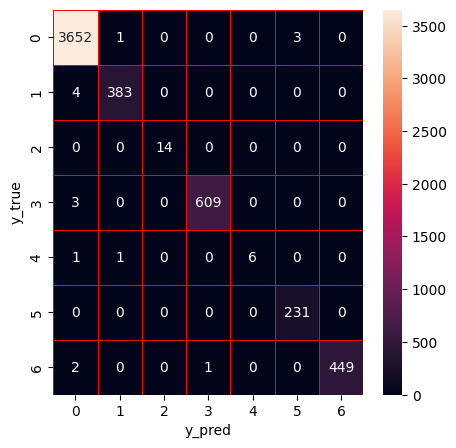

CPU times: user 15.9 s, sys: 492 ms, total: 16.4 s
Wall time: 6.7 s


In [15]:
%%time
# Train the LightGBM algorithm
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       0.99      0.99      0.99       387
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00       612
           4       1.00      0.75      0.86         8
           5       0.99      1.00      0.99       231
           6       1.00      1.00      1.00       452

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.98      5360
weighted avg       1.00      1.00      1.00      5360

Accuracy of XGBoost: 0.9973880597014926
Precision of XGBoost: 0.997392453722596
Recall of XGBoost: 0.9973880597014926
Average F1 of XGBoost: 0.9973617254010698
F1 of XGBoost for each type of attack: [0.99822283 0.99222798 1.         0.99918367 0.85714286 0.99137931
 0.99778271]


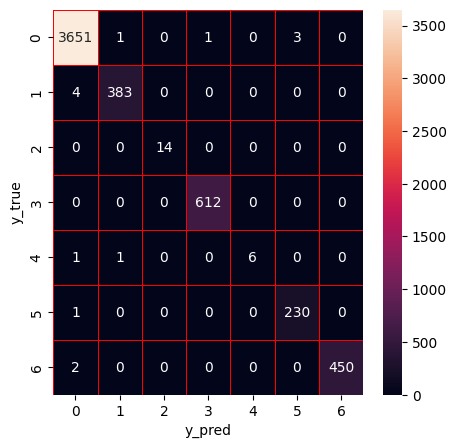

CPU times: user 23.9 s, sys: 1.87 s, total: 25.8 s
Wall time: 7.22 s


In [16]:
%%time
# Train the XGBoost algorithm
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_x = X_train.values
X_test_x = X_test.values

xg.fit(X_train_x, y_train)

y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       0.99      0.99      0.99       387
           2       1.00      1.00      1.00        14
           3       0.99      1.00      1.00       612
           4       1.00      0.62      0.77         8
           5       0.99      1.00      0.99       231
           6       1.00      0.99      0.99       452

    accuracy                           1.00      5360
   macro avg       1.00      0.94      0.96      5360
weighted avg       1.00      1.00      1.00      5360

Accuracy of CatBoost: 0.9960820895522388
Precision of CatBoost: 0.99608757904054
Recall of CatBoost: 0.9960820895522388
Average F1 of CatBoost: 0.9960185226252313
F1 of CatBoost for each type of attack: [0.99753897 0.99222798 1.         0.99510604 0.76923077 0.99137931
 0.9944629 ]


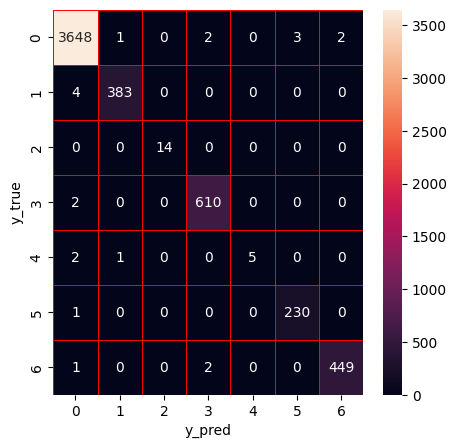

CPU times: user 4min 11s, sys: 12.5 s, total: 4min 23s
Wall time: 50 s


In [17]:
%%time
# Train the CatBoost algorithm
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
cb_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Proposed ensemble model: Leader Class and Confidence Decision Ensemble (LCCDE)

LCCDE aims to achieve optimal model performance by identifying the best-performing base ML model with the highest prediction confidence for each class. 

### Find the best-performing (leading) model for each type of attack among the three ML models

In [18]:
# Leading model list for each class
model=[]
for i in range(len(lg_f1)):
    if max(lg_f1[i],xg_f1[i],cb_f1[i]) == lg_f1[i]:
        model.append(lg)
    elif max(lg_f1[i],xg_f1[i],cb_f1[i]) == xg_f1[i]:
        model.append(xg)
    else:
        model.append(cb)

In [19]:
model

[XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='multi:softprob', ...),
 LGBMClassifier(),
 LGBMClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_st

**Leading Model for Each Type of Attack:**  
0 BENIGN: &emsp; XGBClassifier  
1 Bot:        &emsp;  &emsp;      XGBClassifier   
2 BruteForce:  &emsp;      LGBMClassifier  
3 DoS:        &emsp;   &emsp;   XGBClassifier  
4 Infiltration:  &emsp;       LGBMClassifier  
5 PortScan:  &emsp;       LGBMClassifier  
6 WebAttack:    &emsp;      XGBClassifier  

## LCCDE Prediction

In [20]:
def LCCDE(X_test, y_test, m1, m2, m3):
    i = 0
    t = []
    m = []
    yt = []
    yp = []
    l = []
    pred_l = []
    pro_l = []

    # For each class (normal or a type of attack), find the leader model
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred1 = m1.predict(xi2.reshape(1, -1))      # model 1 (LightGBM) makes a prediction on text sample xi
        y_pred1 = int(y_pred1[0])
        y_pred2 = m2.predict(xi2.reshape(1, -1))      # model 2 (XGBoost) makes a prediction on text sample xi
        y_pred2 = int(y_pred2[0])
        y_pred3 = m3.predict(xi2.reshape(1, -1))      # model 3 (Catboost) makes a prediction on text sample xi
        y_pred3 = int(y_pred3[0])

        p1 = m1.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 1 
        p2 = m2.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 2  
        p3 = m3.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 3  

        # Find the highest prediction probability among all classes for each ML model
        y_pred_p1 = np.max(p1)
        y_pred_p2 = np.max(p2)
        y_pred_p3 = np.max(p3)

        if y_pred1 == y_pred2 == y_pred3: # If the predicted classes of all the three models are the same
            y_pred = y_pred1 # Use this predicted class as the final predicted class

        elif y_pred1 != y_pred2 != y_pred3: # If the predicted classes of all the three models are different
            # For each prediction model, check if the predicted class’s original ML model is the same as its leader model
            if model[y_pred1]==m1: # If they are the same and the leading model is model 1 (LightGBM)
                l.append(m1)
                pred_l.append(y_pred1) # Save the predicted class
                pro_l.append(y_pred_p1) # Save the confidence

            if model[y_pred2]==m2: # If they are the same and the leading model is model 2 (XGBoost)
                l.append(m2)
                pred_l.append(y_pred2)
                pro_l.append(y_pred_p2)

            if model[y_pred3]==m3: # If they are the same and the leading model is model 3 (CatBoost)
                l.append(m3)
                pred_l.append(y_pred3)
                pro_l.append(y_pred_p3)

            if len(l)==0: # Avoid empty probability list
                pro_l=[y_pred_p1,y_pred_p2,y_pred_p3]

            elif len(l)==1: # If only one pair of the original model and the leader model for each predicted class is the same
                y_pred=pred_l[0] # Use the predicted class of the leader model as the final prediction class

            else: # If no pair or multiple pairs of the original prediction model and the leader model for each predicted class are the same
                max_p = max(pro_l) # Find the highest confidence
                
                # Use the predicted class with the highest confidence as the final prediction class
                if max_p == y_pred_p1:
                    y_pred = y_pred1
                elif max_p == y_pred_p2:
                    y_pred = y_pred2
                else:
                    y_pred = y_pred3  
        
        else: # If two predicted classes are the same and the other one is different
            n = mode([y_pred1,y_pred2,y_pred3]) # Find the predicted class with the majority vote
            y_pred = model[n].predict(xi2.reshape(1, -1)) # Use the predicted class of the leader model as the final prediction class
            y_pred = int(y_pred[0]) 

        yt.append(yi)
        yp.append(y_pred) # Save the predicted classes for all tested samples
    return yt, yp

In [21]:
%%time
# Implementing LCCDE
yt, yp = LCCDE(X_test, y_test, m1 = lg, m2 = xg, m3 = cb)

CPU times: user 3min 43s, sys: 1min, total: 4min 43s
Wall time: 51.3 s


In [22]:
# The performance of the proposed lCCDE model
print("Accuracy of LCCDE: "+ str(accuracy_score(yt, yp)))
print("Precision of LCCDE: "+ str(precision_score(yt, yp, average='weighted')))
print("Recall of LCCDE: "+ str(recall_score(yt, yp, average='weighted')))
print("Average F1 of LCCDE: "+ str(f1_score(yt, yp, average='weighted')))
print("F1 of LCCDE for each type of attack: "+ str(f1_score(yt, yp, average=None)))

Accuracy of LCCDE: 0.9973880597014926
Precision of LCCDE: 0.9973936463405039
Recall of LCCDE: 0.9973880597014926
Average F1 of LCCDE: 0.9973616275366365
F1 of LCCDE for each type of attack: [0.99835976 0.99351492 1.         0.99755102 0.85714286 0.99137931
 0.99778271]


In [23]:
# Comparison: The F1-scores for each base model
print("F1 of LightGBM for each type of attack: "+ str(lg_f1))
print("F1 of XGBoost for each type of attack: "+ str(xg_f1))
print("F1 of CatBoost for each type of attack: "+ str(cb_f1))

F1 of LightGBM for each type of attack: [0.99808691 0.99222798 1.         0.99672668 0.85714286 0.99354839
 0.99667037]
F1 of XGBoost for each type of attack: [0.99822283 0.99222798 1.         0.99918367 0.85714286 0.99137931
 0.99778271]
F1 of CatBoost for each type of attack: [0.99753897 0.99222798 1.         0.99510604 0.76923077 0.99137931
 0.9944629 ]


**Conclusion**: The performance (F1-score) of the proposed LCCDE ensemble model on each type of attack detection is higher than any base ML model.